# Importing necessary libraries

In [2]:
import skimage.data
import skimage.transform
 
import os
import numpy as np
import cv2
import pickle
from imutils import paths

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.models import Model
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.engine.input_layer import Input
from keras.utils.vis_utils import plot_model
from keras import backend as K

# set the matplotlib backend so figures can be saved in the background
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.use("Agg")
# Allow image embeding in notebook
%matplotlib inline

Using TensorFlow backend.


In [3]:
#data set paths
BTS_ROOT = '/media/prithvi/DATA/acads/NNFL/assignment 2/BelgiumTS datasets/'
BTSC_TRAINING = os.path.join(BTS_ROOT,"BelgiumTSC_Training")
BTSC_TESTING= os.path.join(BTS_ROOT,"BelgiumTSC_Testing")
BTSC_TRAINING_SMALL = os.path.join(BTS_ROOT,"BelgiumTSC_Training_small")

# Loading the Dataset

In [4]:
#function to load data from data_dir
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [5]:
#loading the data
# images, labels = load_data(BTSC_TRAINING)
images, labels = load_data(BTSC_TRAINING)

## Displaying an example image from each class

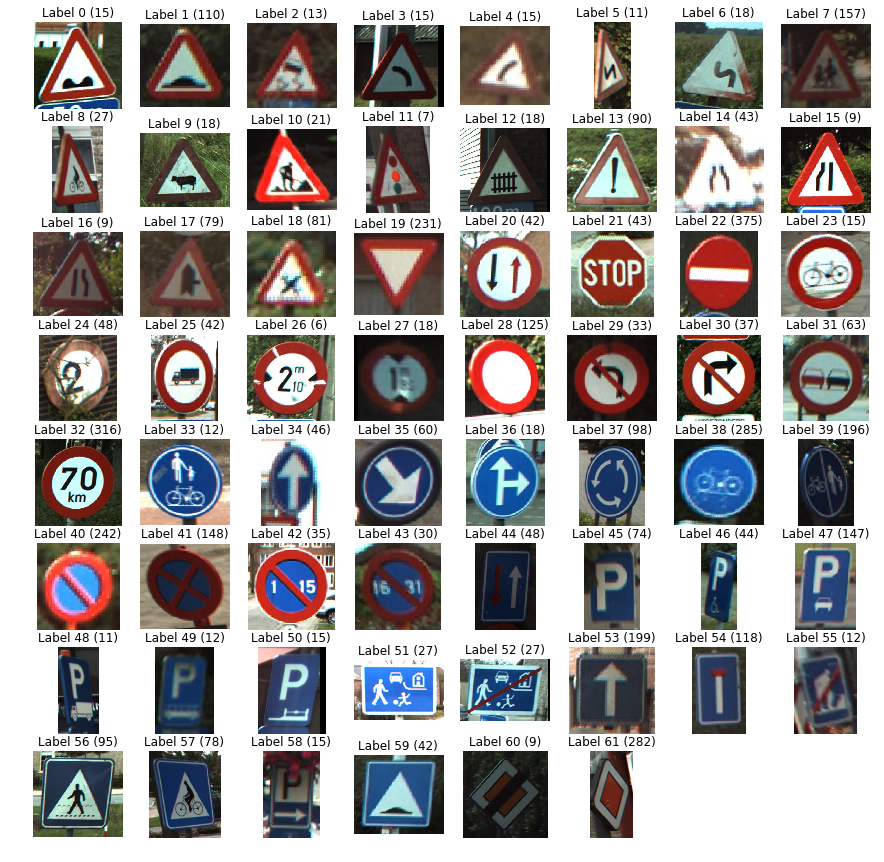

In [6]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

## Resizing Images and One-Hot encoding class labels

In [7]:
'''
resizing, training data
storing it as np array of floats normalised to interval [0,1]
'''
trainX = np.array([ cv2.resize(image,(48,48)) for image in images ] , dtype="float")/255.0

#converting labels to one hot encoding
lb= LabelBinarizer()
trainY = lb.fit_transform(labels) #finds unique labels and one hot encodes

#reading test data
testims,testLabels= load_data(BTSC_TESTING)
testX = np.array([ cv2.resize(image,(48,48)) for image in testims], dtype="float")/255.0
testY = lb.transform(testLabels) #transform() just encodes based on classes detected in fit_transform()


In [8]:
print("No. of training examples = ", len(trainX))
print(trainX[0].shape)
print("No. of test examples = ",len(testX))
print("No. of classes =",len(lb.classes_))

No. of training examples =  4575
(48, 48, 3)
No. of test examples =  2554
No. of classes = 62


# Architecture


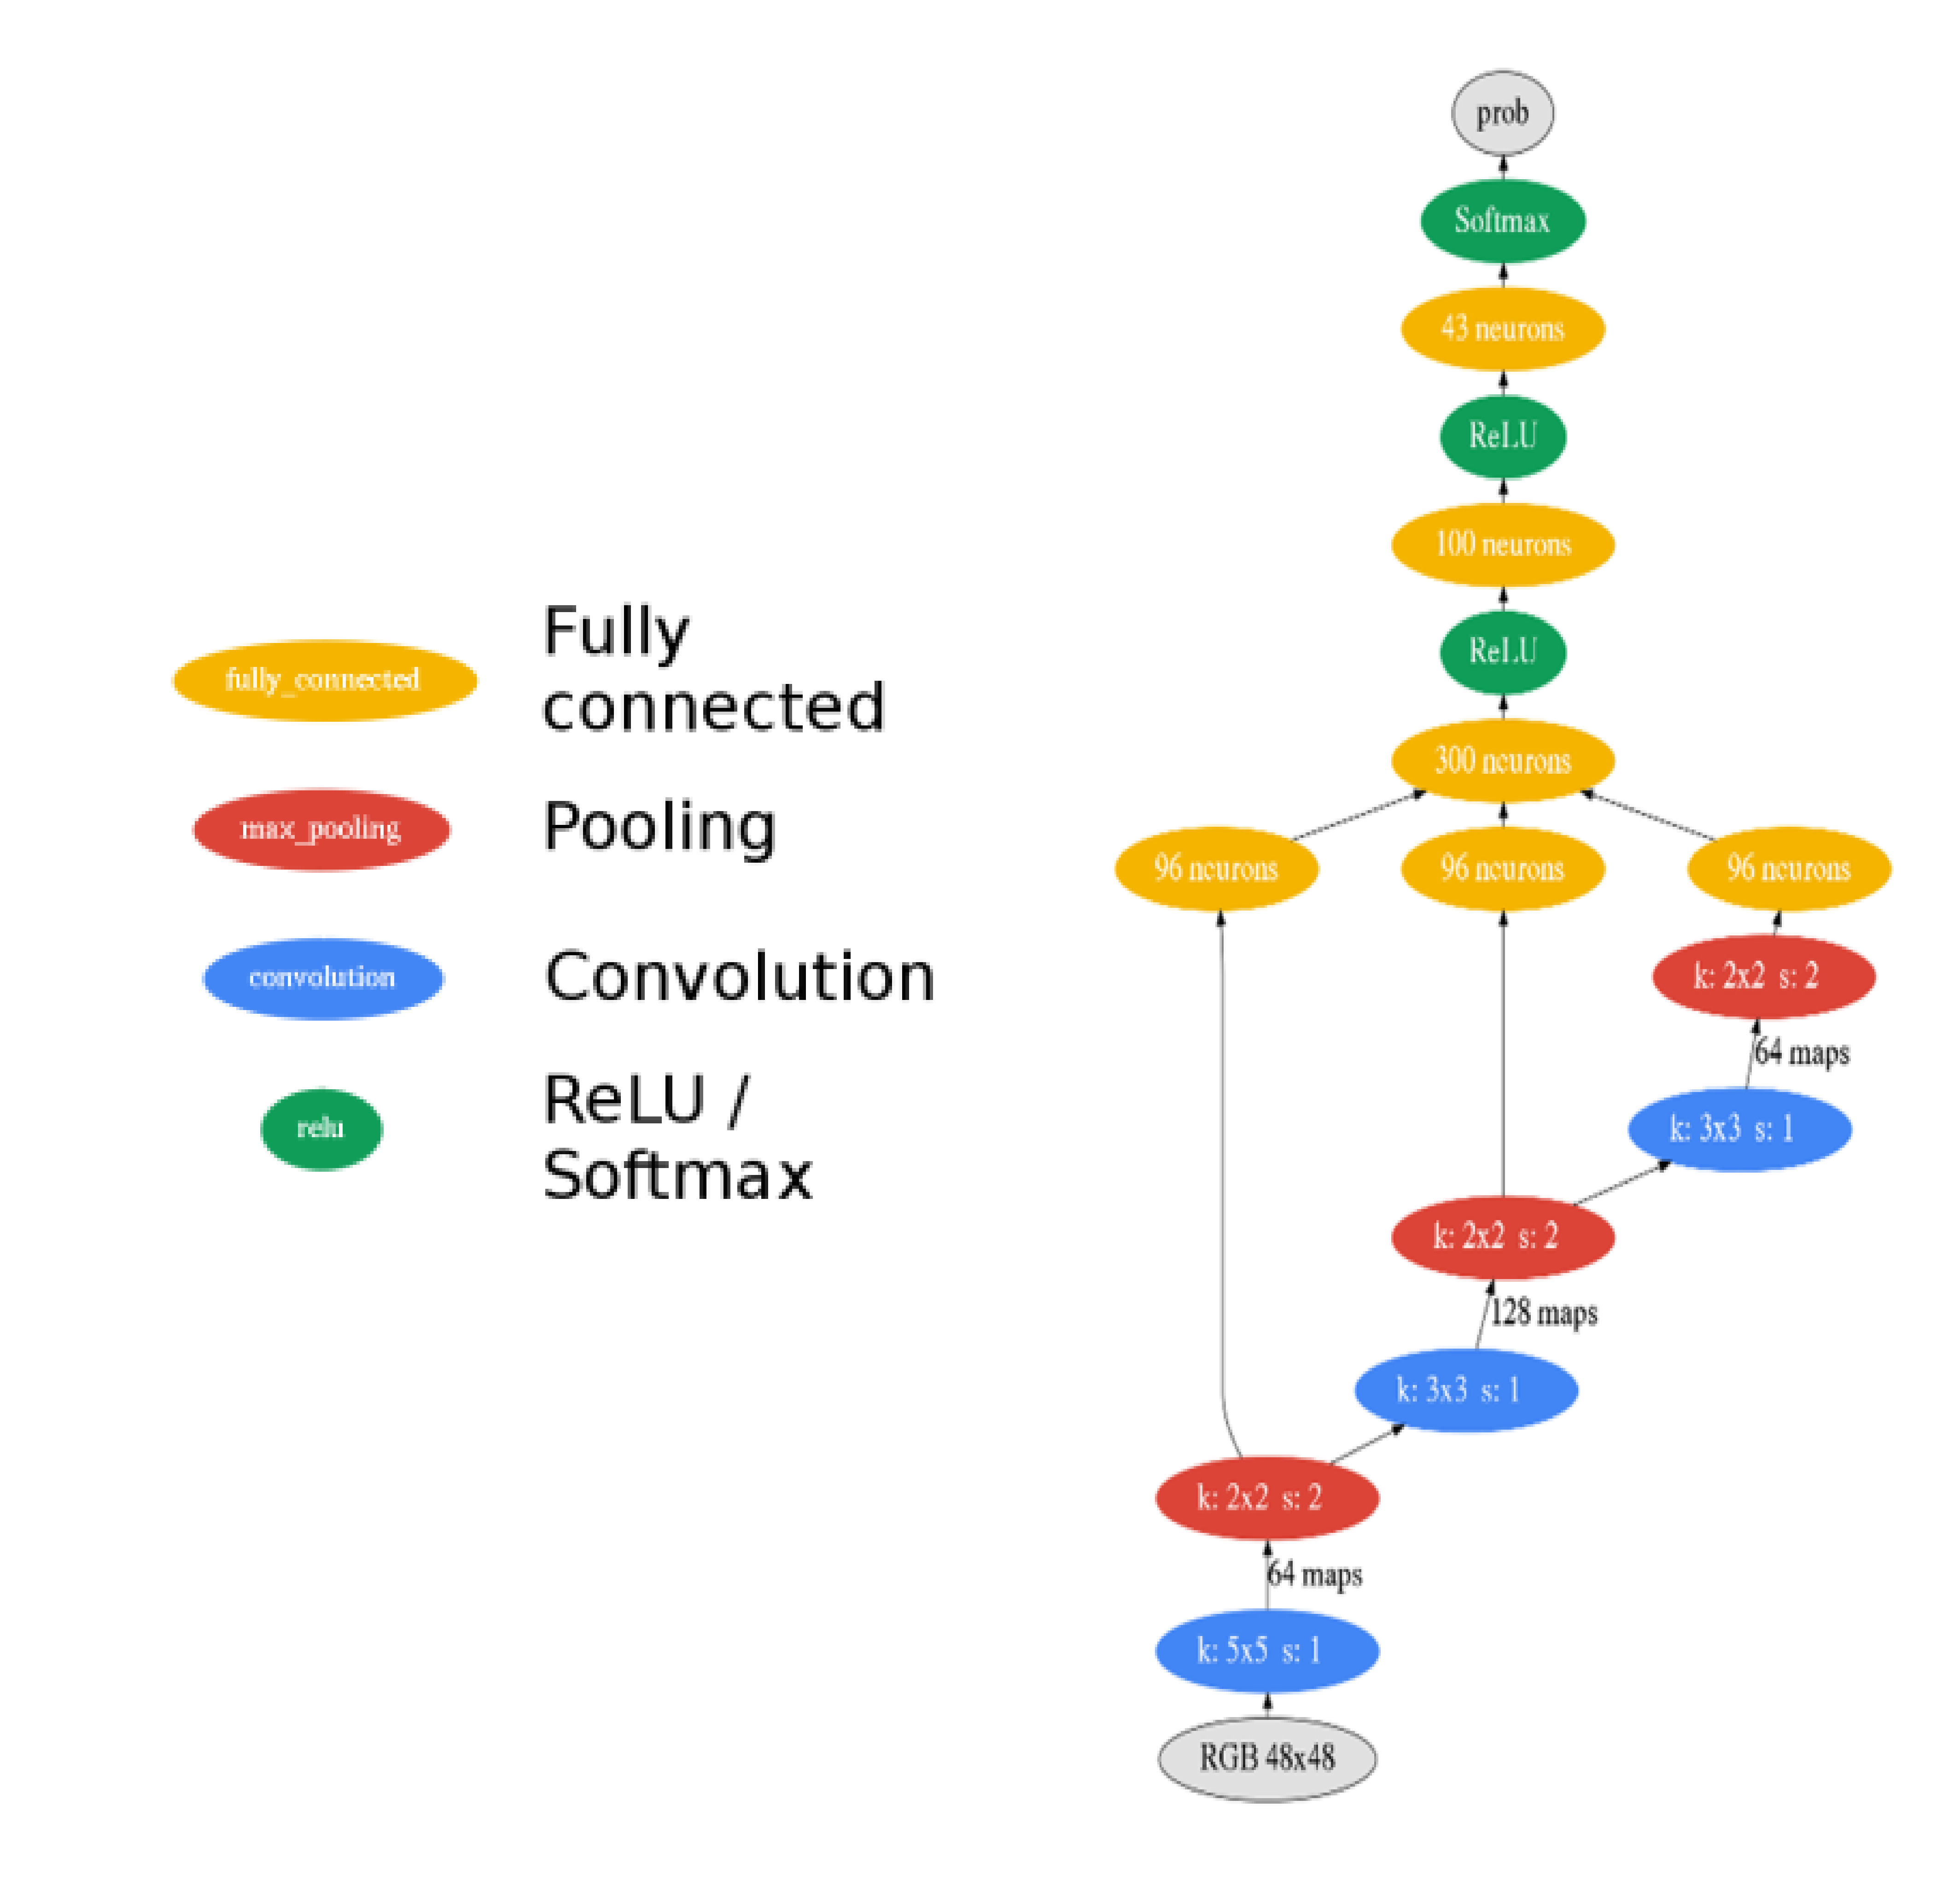

In [104]:
model_from_paper = mpimg.imread("architecture.png")
legend =  skimage.data.imread("legend.png")
plt.figure(figsize=(10,10),dpi=512)
plt.subplot(1,2,1)
plt.imshow(legend,aspect='equal')
plt.axis("off");
plt.subplot(1,2,2)
plt.imshow(model_from_paper,aspect='auto')
plt.axis('off');

# Making the Network

## Creating Layers and compiling the model

In [114]:
#inpute layer
ip = Input(shape=trainX[0].shape)

#first convolutional layer
c1 = Conv2D(filters=64, kernel_size=(5,5), strides=1, padding="same")(ip)

#first pooling layer
p1 = MaxPooling2D(pool_size = (2,2), strides=2)(c1)
p1 = Dropout(0.25)(p1)

#second convolutional layer
c2 = Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same")(p1)

#second pooling layer
p2 = MaxPooling2D(pool_size = (2,2), strides=2)(c2)
p2 = Dropout(0.25)(p2)

#third convolutional layer
c3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same")(p2)

#third pooling layer
p3 = MaxPooling2D(pool_size = (2,2), strides=2)(c3)
p3 = Dropout(0.25)(p3)

#flattening outputs of p1,p2 and p3
fl1 = Flatten()(p1)
fl2 = Flatten()(p2)
fl3 = Flatten()(p3)

#fully connected layers
fc1 = Dense(96)(fl1)
fc1 = Dropout(0.25)(fc1)

fc2 = Dense(96)(fl2)
fc2 = Dropout(0.25)(fc2)

fc3 = Dense(96)(fl3)
fc3 = Dropout(0.25)(fc3)

#merging layer
m1 = Concatenate()([fc1, fc2, fc3])

#fully connected layer
fc4 = Dense(300, activation = 'relu')(m1)
fc4 = Dropout(0.25)(fc4)

#fully connected
fc5 = Dense(100,activation = 'relu')(fc4)
fc5 = Dropout(0.25)(fc5)

#fully connected (final layer - 62 outputs)
fc6 = Dense(len(lb.classes_), activation = 'softmax')(fc5)


#model
model = Model(inputs = ip, outputs = fc6)

# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.03
MOMENTUM = 0.3

#INIT_LR = 0.03 and MOMENTUM = 0.3 are the best settings found so far

# compile the model using SGD as our optimizer and categorical
# cross-entropy loss (softmax loss)
opt = SGD(lr = INIT_LR, momentum = MOMENTUM)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


In [115]:
print(model.summary())
plot_model(model, show_shapes= True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 48, 48, 64)   4864        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 24, 24, 64)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 24, 24, 64)   0           max_pooling2d_32[0][0]           
__________________________________________________________________________________________________
conv2d_33 

## Architecture of the network made

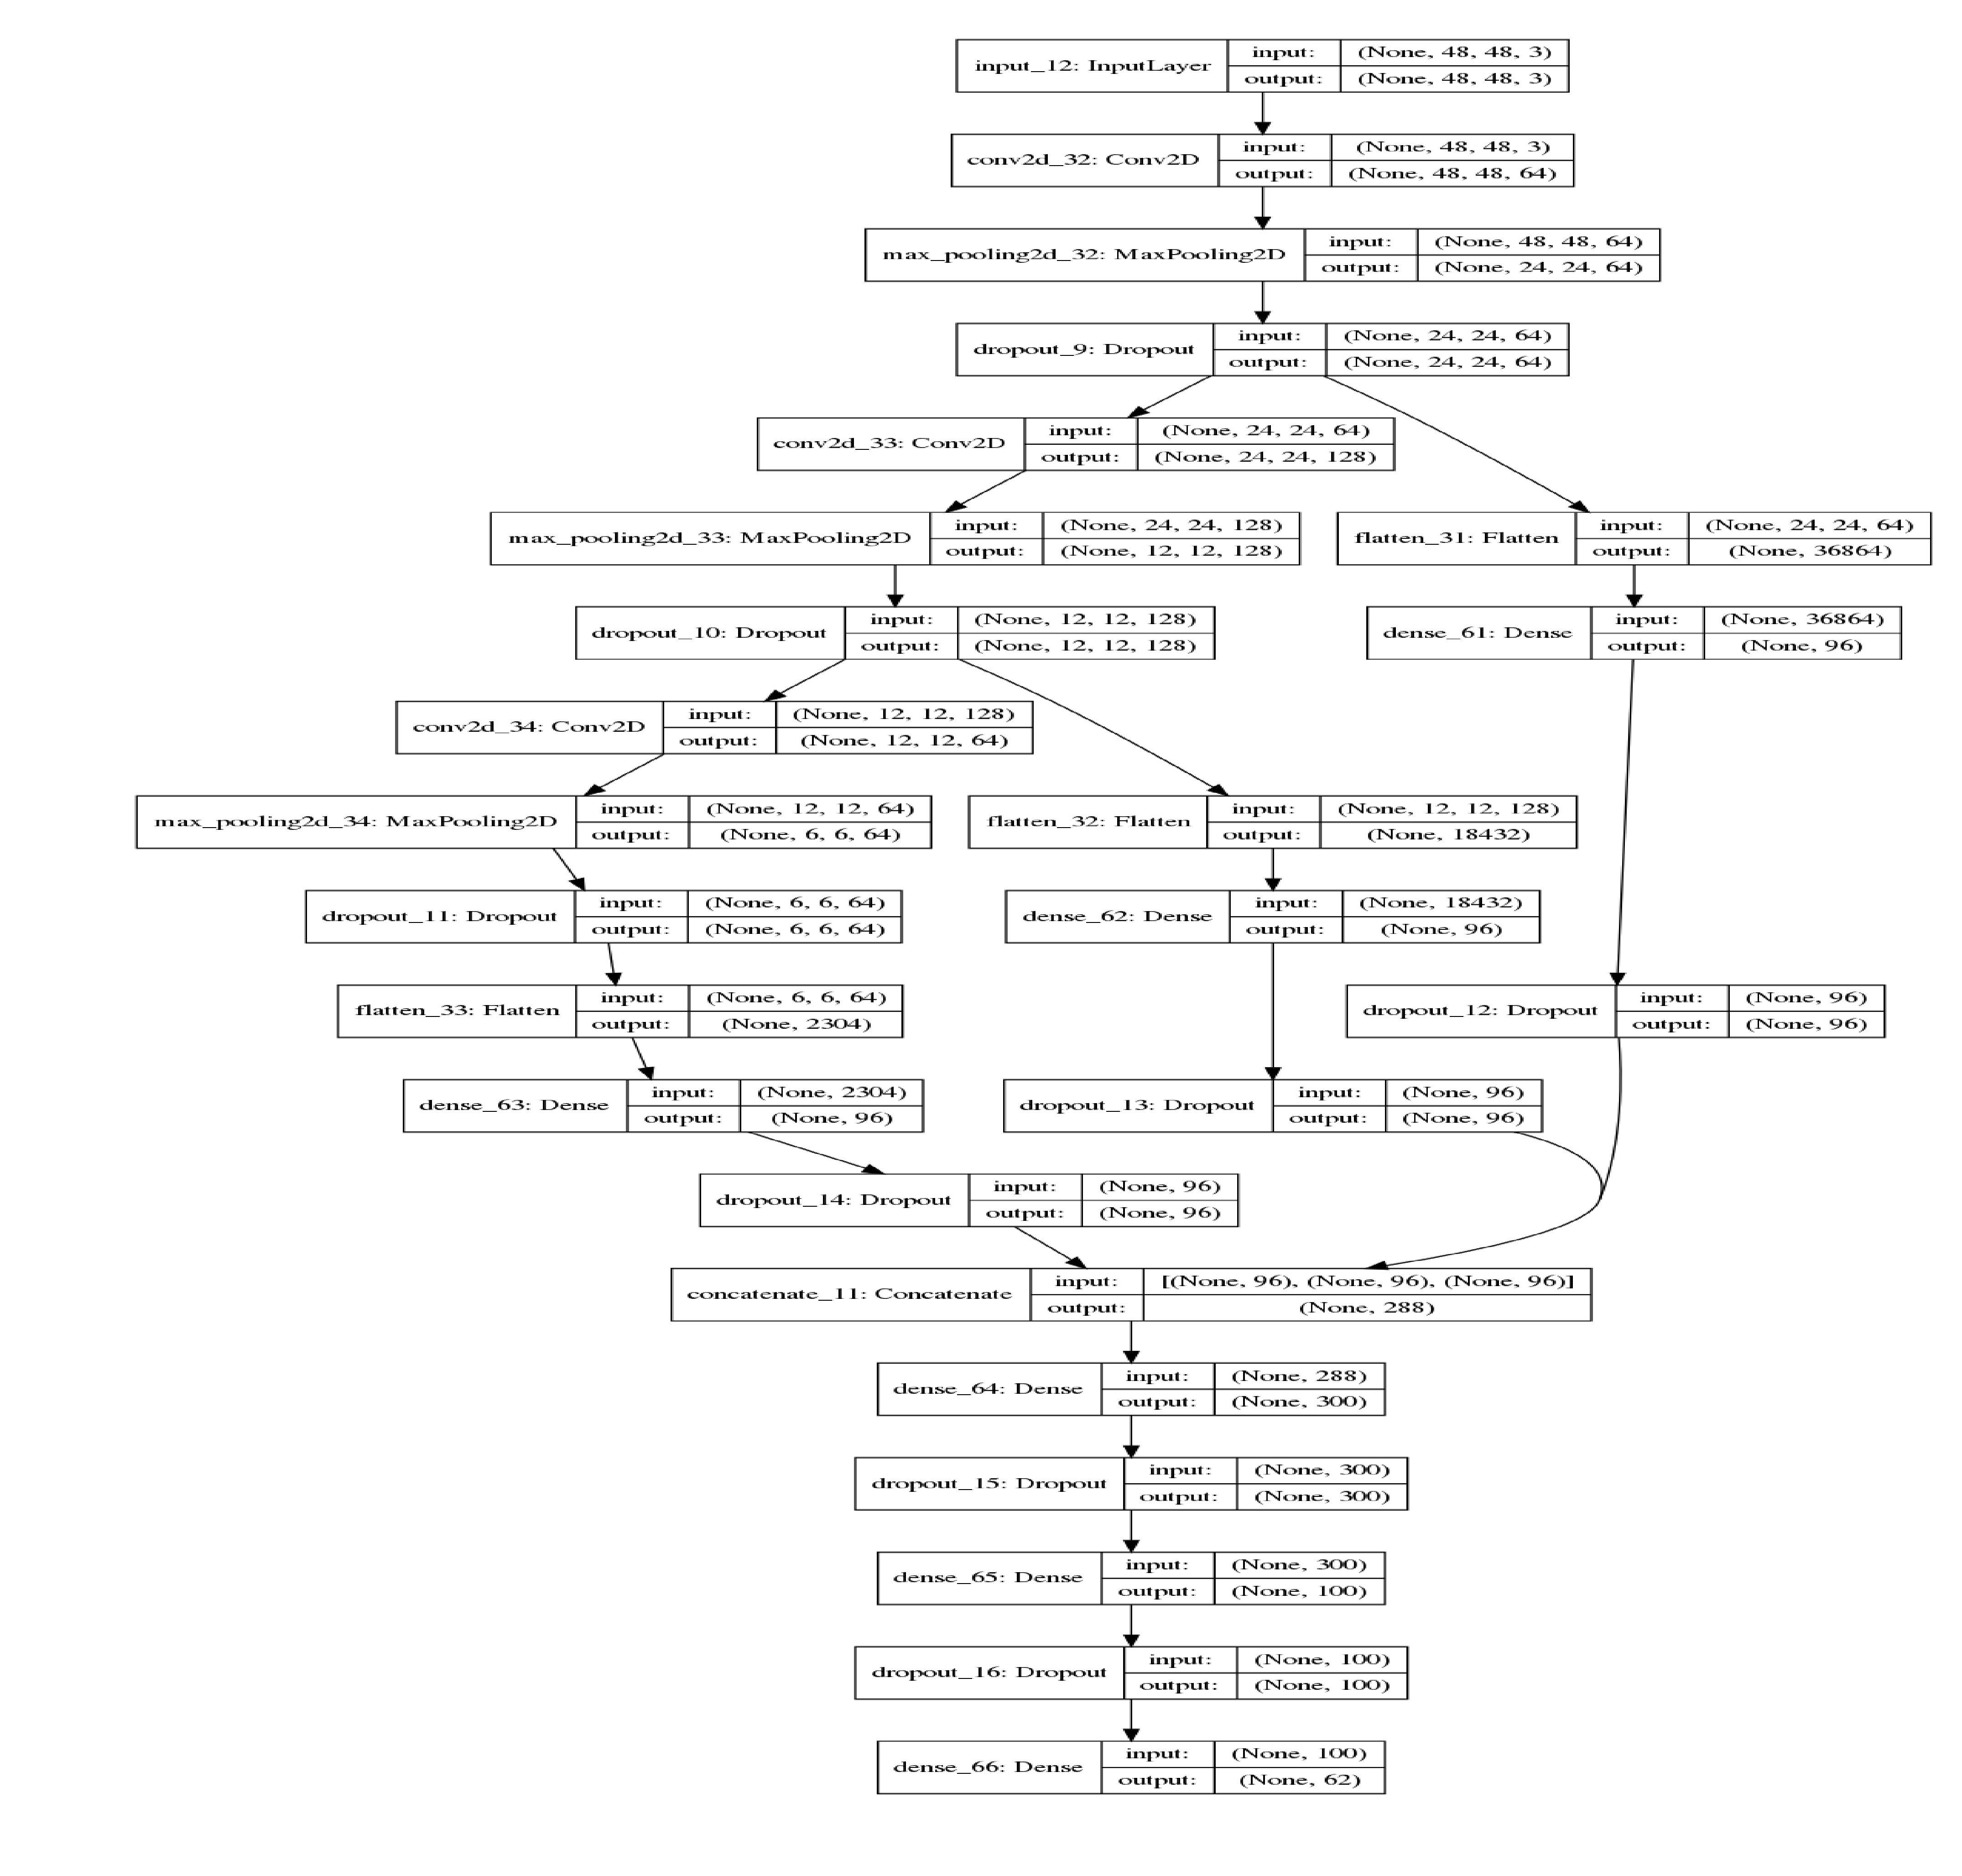

In [116]:

model_diagram=skimage.data.imread("model.png")
plt.figure(figsize=(10,10),dpi=512)
plt.imshow(model_diagram,aspect='auto')
plt.axis("off");

# Training

In [119]:
#train the model
EPOCHS = 50
BATCH_SIZE = 32

gen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1, )
H = model.fit_generator(gen.flow(trainX,trainY), validation_data=(testX,testY), steps_per_epoch = len(trainX)//BATCH_SIZE, epochs=EPOCHS)

Epoch 1/50
142/142 [==============================] - 49s 345ms/step - loss: 0.3526 - acc: 0.8875 - val_loss: 0.2166 - val_acc: 0.9381
Epoch 2/50
142/142 [==============================] - 50s 350ms/step - loss: 0.3829 - acc: 0.8818 - val_loss: 0.2079 - val_acc: 0.9424
Epoch 3/50
142/142 [==============================] - 49s 346ms/step - loss: 0.3714 - acc: 0.8840 - val_loss: 0.2490 - val_acc: 0.9330
Epoch 4/50
142/142 [==============================] - 49s 346ms/step - loss: 0.3412 - acc: 0.8886 - val_loss: 0.2332 - val_acc: 0.9370
Epoch 5/50
142/142 [==============================] - 52s 364ms/step - loss: 0.3184 - acc: 0.8965 - val_loss: 0.2053 - val_acc: 0.9432
Epoch 6/50
142/142 [==============================] - 52s 367ms/step - loss: 0.3229 - acc: 0.8961 - val_loss: 0.1946 - val_acc: 0.9538
Epoch 7/50
142/142 [==============================] - 49s 344ms/step - loss: 0.3218 - acc: 0.8998 - val_loss: 0.2447 - val_acc: 0.9346
Epoch 8/50
142/142 [==============================] - 5

In [122]:
# save the model and label binarizer to disk
model.save("model_dropout25")
f = open("binarizer", "wb")
f.write(pickle.dumps(lb))
f.close()

# Testing

In [121]:
# evaluate the network
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), labels=lb.classes_))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.96      1.00      0.98        27
           2       1.00      0.71      0.83         7
           3       0.75      0.50      0.60         6
           4       0.92      0.92      0.92        12
           5       1.00      0.67      0.80         3
           6       0.62      0.83      0.71         6
           7       0.99      1.00      0.99        90
           8       0.63      1.00      0.77        12
           9       1.00      1.00      1.00         7
          10       1.00      0.96      0.98        28
          11       1.00      1.00      1.00         4
          12       1.00      0.67      0.80         3
          13       1.00      0.90      0.95        39
          14       0.62      1.00      0.77        15
          15       1.00      1.00      1.00         5
          16       1.00      0.25      0.40        12
          17       0.98    

## Plotting traing curves

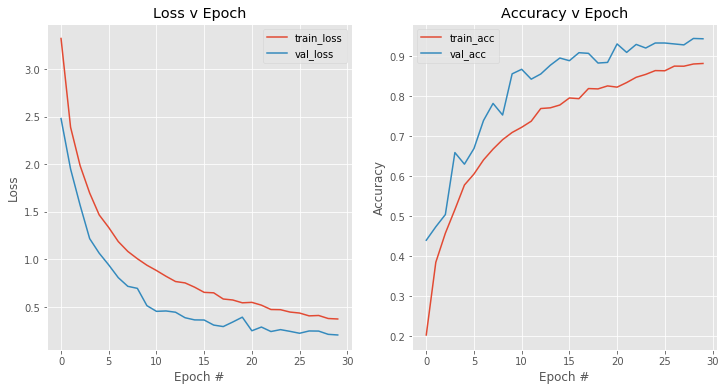

In [118]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
plt.title("Training Loss and Accuracy (Simple NN)")
plt.subplot(1,2,1)
plt.title("Loss v Epoch")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.title("Accuracy v Epoch")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(".")

In [8]:
lb.classes_


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])